# Exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as stats
from talib import ATR, NATR

In [78]:
sns.set_theme()

In [15]:
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Purpose of exploration (To detect patterns early on)

* Descriptive statistics of the data
* Examining distribution of returns and outliers
* Examining influence of past on the future
* Possible relationship between OHLCV features to returns
* How returns on a stock interacts with returns on index fund
* What models we might use in order to carry out trading


In [4]:
ticker = 'msft'

In [5]:
#Import data

stock = pd.read_hdf('../data/assets.h5', 'yfinance/prices/train/{}'.format(ticker))

## 1. Descriptive Stats and Summarization

In [6]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-04 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2515 non-null   float64
 1   High       2515 non-null   float64
 2   Low        2515 non-null   float64
 3   Close      2515 non-null   float64
 4   Adj Close  2515 non-null   float64
 5   Volume     2515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.5 KB


In [7]:
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001,23.623901,38409100
2010-01-05,30.850000,31.100000,30.639999,30.959999,23.631538,49749600
2010-01-06,30.879999,31.080000,30.520000,30.770000,23.486511,58182400
2010-01-07,30.629999,30.700001,30.190001,30.450001,23.242250,50559700
2010-01-08,30.280001,30.879999,30.240000,30.660000,23.402550,51197400


In [8]:
stock.describe() #Volume may have to be normalized for comparison

,Open,High,Low,Close,Adj Close,Volume
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,56.270426,56.728847,55.775523,56.281857,50.856181,3.993488e+07
std,33.821095,34.053276,33.521595,33.809735,34.084177,2.299236e+07
min,23.090000,23.320000,22.730000,23.010000,17.725111,7.425600e+06
25%,29.590000,29.800000,29.205000,29.559999,23.669188,2.431615e+07
50%,44.529999,44.980000,44.080002,44.400002,38.970509,3.424840e+07
75%,70.755001,71.264999,70.099998,70.760002,65.786594,4.978645e+07
max,159.449997,159.550003,158.220001,158.960007,154.152023,3.193179e+08


In [18]:
#let's drop the close column and use Adj Close instead since it considers any dividends paid
stock.drop('Close', axis = 1, inplace = True)
stock = stock.rename(columns = {'Adj Close': 'Close'})

In [19]:
#constructing returns
stock['return_1d'] = np.log(stock.Close/stock.Close.shift(1))

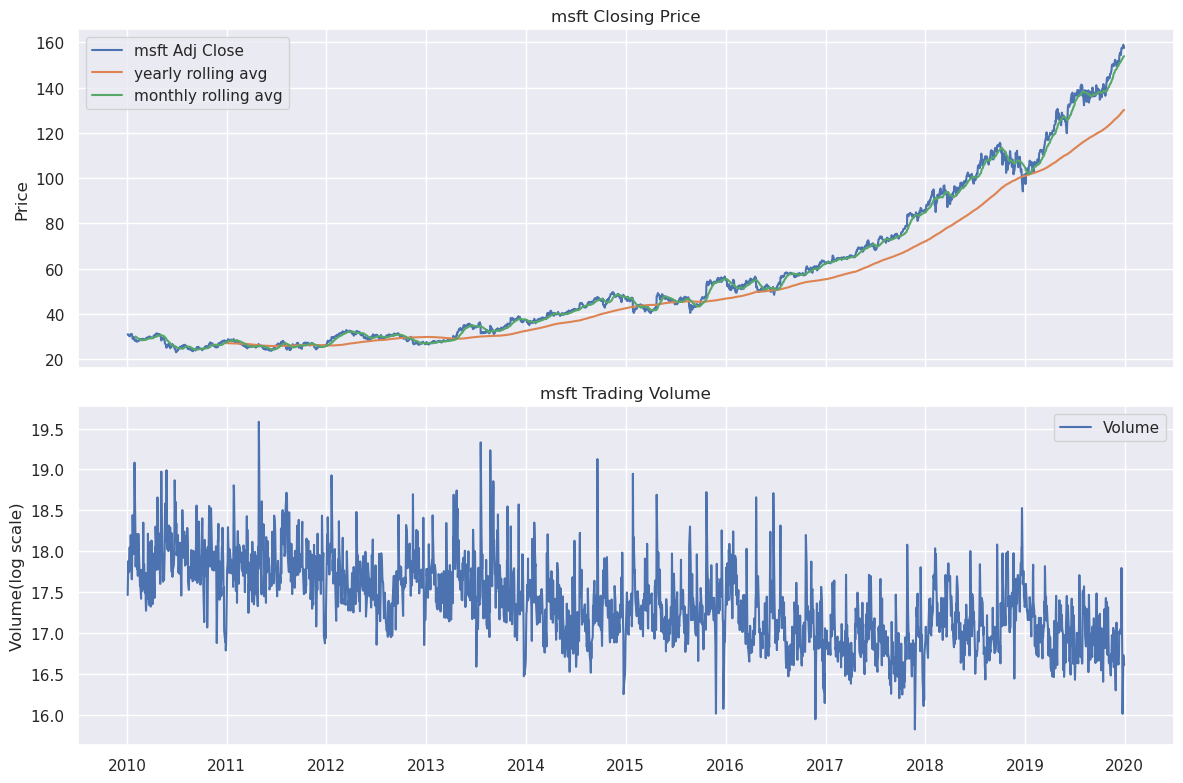

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,8))
ax[0].plot(stock['Close'], label = f'{ticker} Adj Close')
ax[0].plot(stock['Close'].rolling(252).mean(), label = 'yearly rolling avg')
ax[0].plot(stock['Close'].rolling(21).mean(), label = 'monthly rolling avg')

ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(np.log(stock['Volume']), label = 'Volume')
ax[1].set(title = f'{ticker} Trading Volume', ylabel = 'Volume(log scale)')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
save_fig("msft_price_volume")

Closing price is increasing on an average whilst volume is decreasing
<br>This suggests that Microsoft might be paying dividends

## 2. Examining distribution of returns

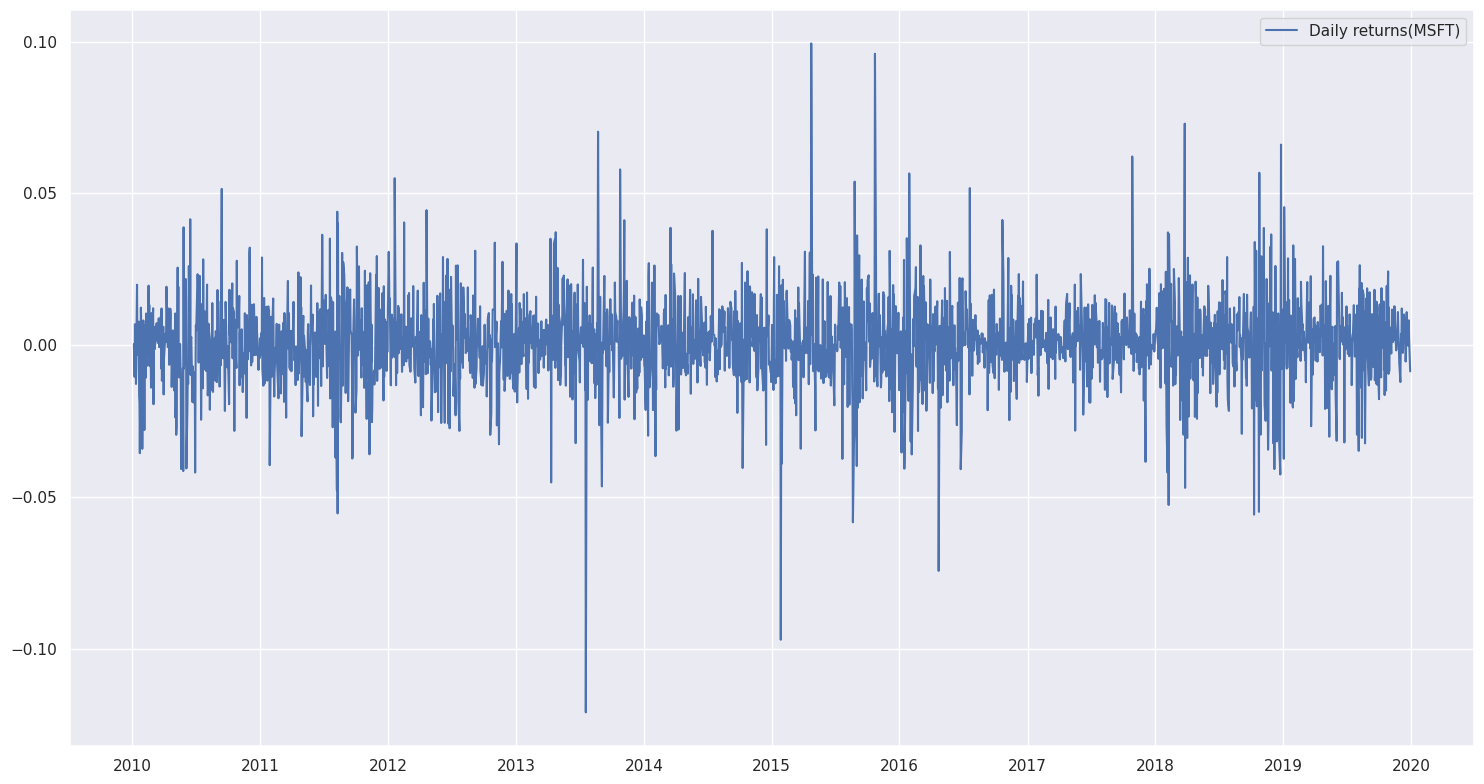

In [22]:
#Basic plot
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(stock['return_1d'], label="Daily returns(MSFT)")
ax.grid(True)
ax.legend()
save_fig("plot_returns_MSFT")

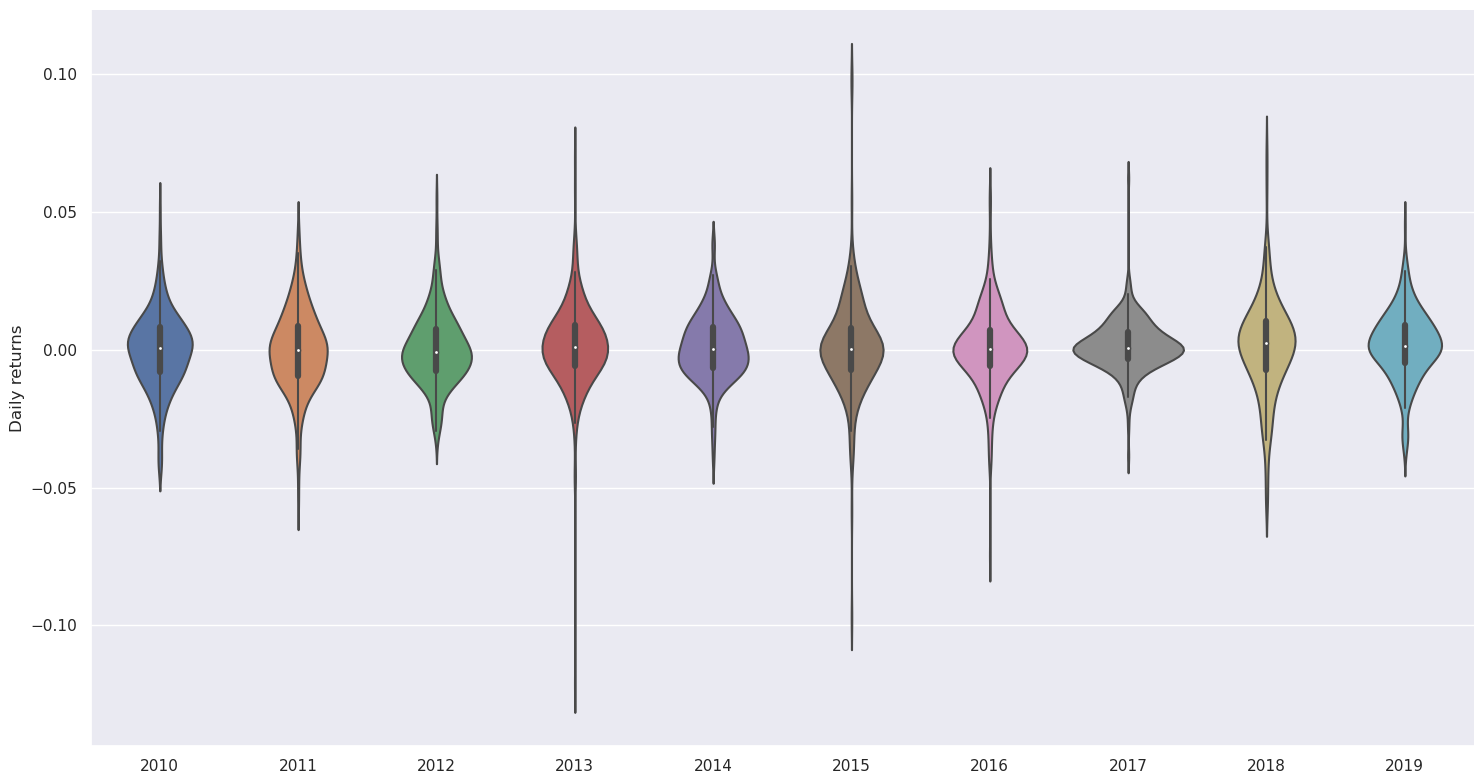

In [27]:
#possible outliers, 
v = sns.violinplot(data=stock, x = stock.index.year, y = stock['return_1d'])
v.set_xlabel(None)
v.set_ylabel("Daily returns")
v.figure.set_size_inches(15, 8)
sns.despine()
save_fig("yearly_returns_dist")

 **Distribution of daily returns**
 - Appears to have thin tails (leptokurtic)
 - This hints that assuming normality in data might not be a good idea

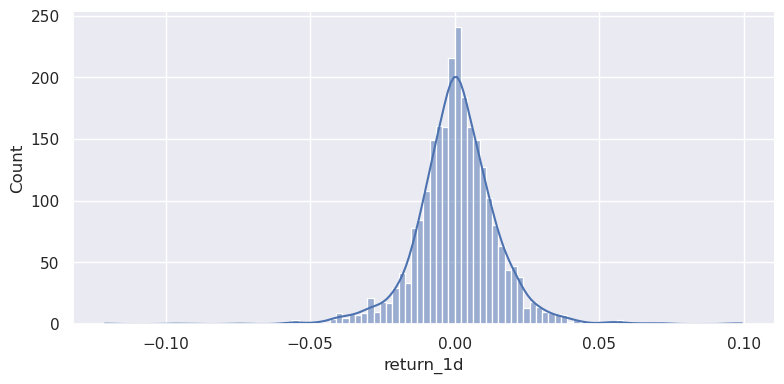

In [44]:
g = sns.displot(stock, x="return_1d", aspect=3, kde=True)
g.figure.set_size_inches(8, 4)
#plt.title("Distribution of daily returns on MSFT")
save_fig('distribution_returns_MSFT')
#

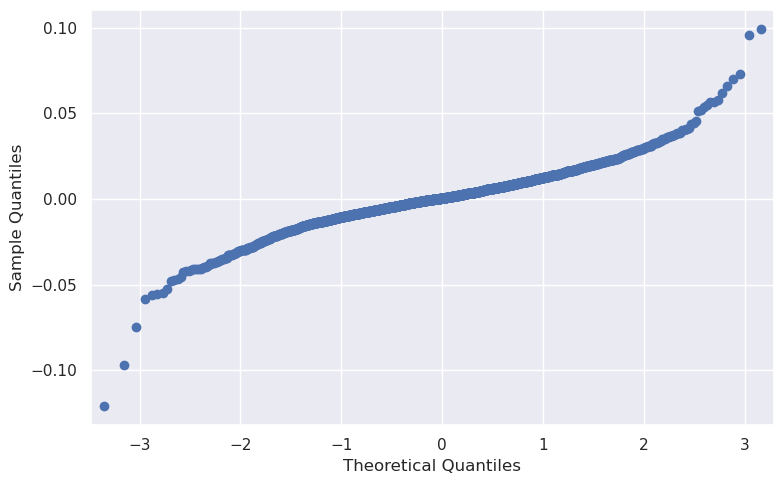

In [49]:
# Indeed there appears to be non-normality in data
fig, ax = plt.subplots(1,1, figsize= (8,5))
sm.qqplot(stock.return_1d, stats.norm, ax=ax)
ax.grid(True)
save_fig("QQ_plot_returns_msft")

**Distribution with respect to time**

## 3. Influence of past on future

In [50]:
lags = [1,5, 21,63]
returns = pd.DataFrame()
for lag in lags:
    returns[f'{lag}d'] = np.log(stock.Close/stock.Close.shift(lag))

In [51]:
returns['f_return'] = returns['1d'].shift(-1)

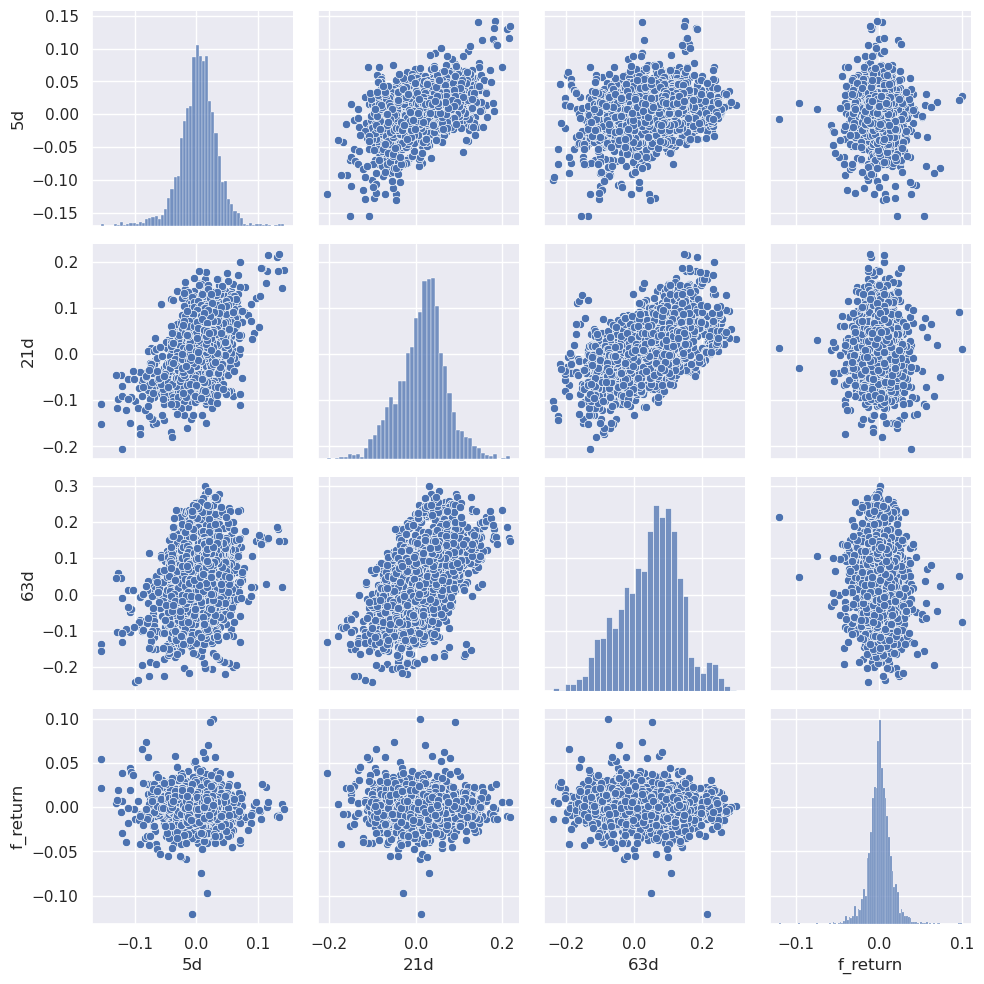

In [54]:
pair = sns.pairplot(returns.drop('1d', axis = 1))
save_fig('corr_forward_returns_MSFT')
#pair.map_upper(False)
# previous returns can't explain forward one day returns very well
# there appears to be a correlation between monthly returns to quaterly returns

**what about relationship between past quaterly returns to future monthly returns?**

In [55]:
past_future = pd.DataFrame()
past_future['63d'] = np.log(stock.Close/stock.Close.shift(63))
past_future['f_21d'] = np.log(stock.Close/stock.Close.shift(-21))

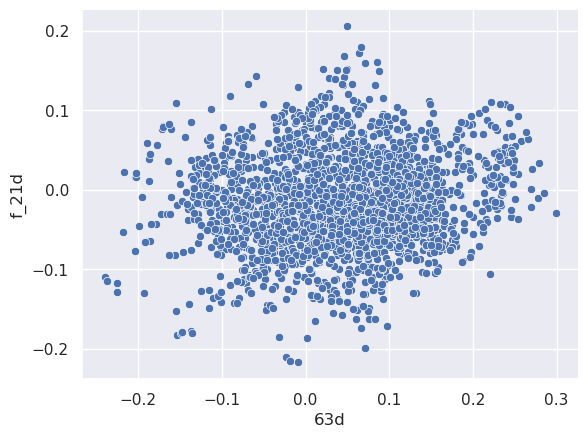

In [56]:
sns.scatterplot(x=past_future['63d'], y=past_future['f_21d'])
sns.despine()

**A better approach would be to see ACF plot and examine stationarity**

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


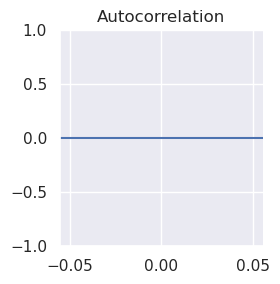

In [67]:
x = sm.graphics.tsa.plot_acf(stock['return_1d'], lags= 63)
sns.despine()
x.set_figwidth(3)
x.set_figheight(3)
save_fig("autocorr_returns_msft")
plt.show()

#returns are not autocorrelated but stationary 

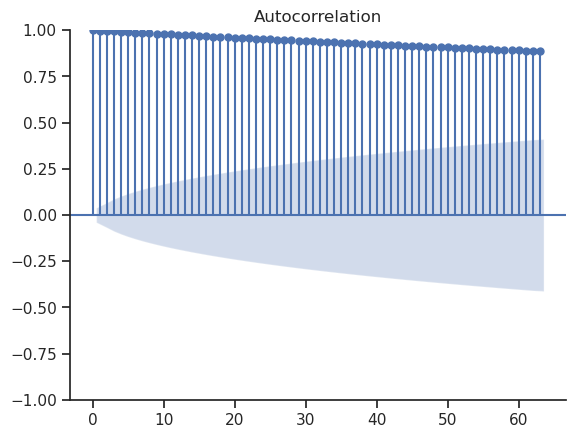

<Figure size 640x480 with 0 Axes>

In [270]:
sm.graphics.tsa.plot_acf(stock['Close'], lags= 63)
sns.despine()
plt.show()
save_fig("autocorr_close_msft")
#prices are correlated and exhibit nonstationarity

**This implies that using lagged returns to predict future returns is unreliable**

## 4. How OHLCV data is correlated to daily returns

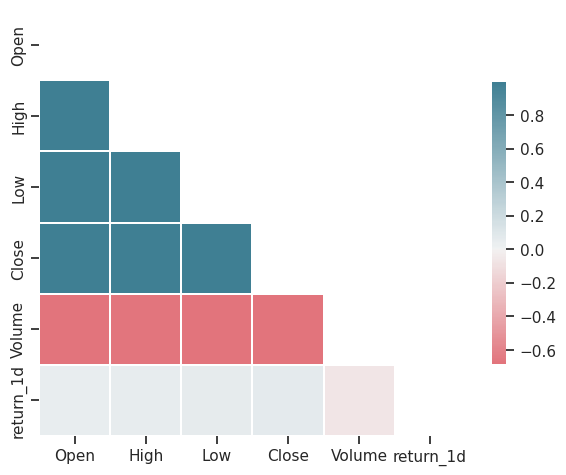

In [69]:
# pricing data doesn't correlate to returns well
sns.set_style('ticks')
corr_mat = stock.corr(method='spearman')
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(corr_mat,dtype=bool))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
h = sns.heatmap(corr_mat,mask=mask, cmap=cmap, center = 0,square=True,
           linewidths = .2, cbar_kws={"shrink" : .5})
h.figure.set_size_inches(6, 6)
#plt.title('Correlation of OHLCV to daily returns')
ax.grid(False)
save_fig('corr_ohlcv_MSFT')

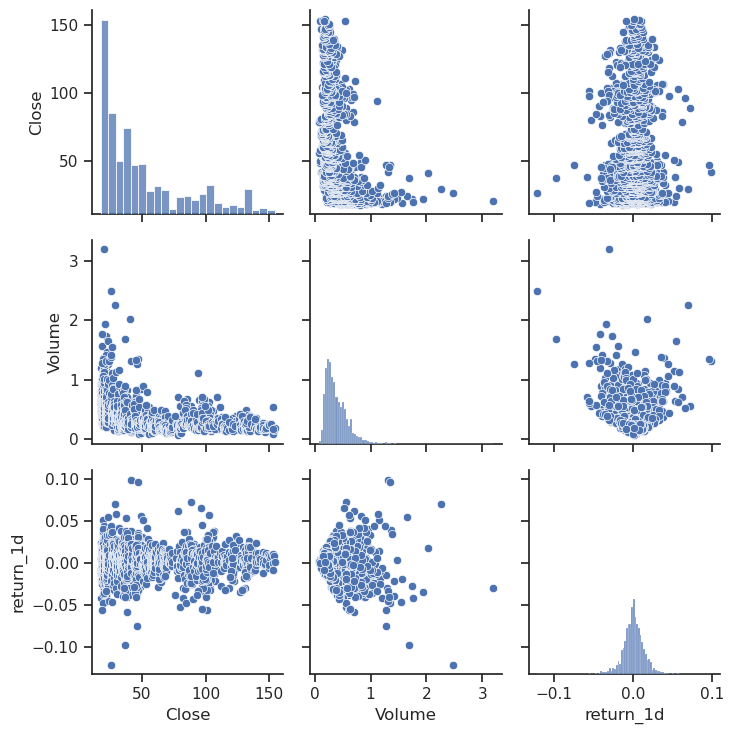

In [272]:
#A full pair plot reveals closing price is enough to show relationship with returns
#closing price, open, high, low are highly correlated
sns.pairplot(stock[['Close', 'Volume', 'return_1d']])
plt.tight_layout()
save_fig("pairplot_msft_ohlcv")

In [267]:
# we need more features to predict market direction

### how returns and volatility interact

When volatility is low, returns are high <br>
when volatility is high, returns are low 

**This hints that we might have to engineer more features**

In [218]:
vol_stock = stock['return_1d'].rolling(window = 252).std() * np.sqrt(252)
sharpe_stock = stock['return_1d'].rolling(window = 252).mean()/vol_stock

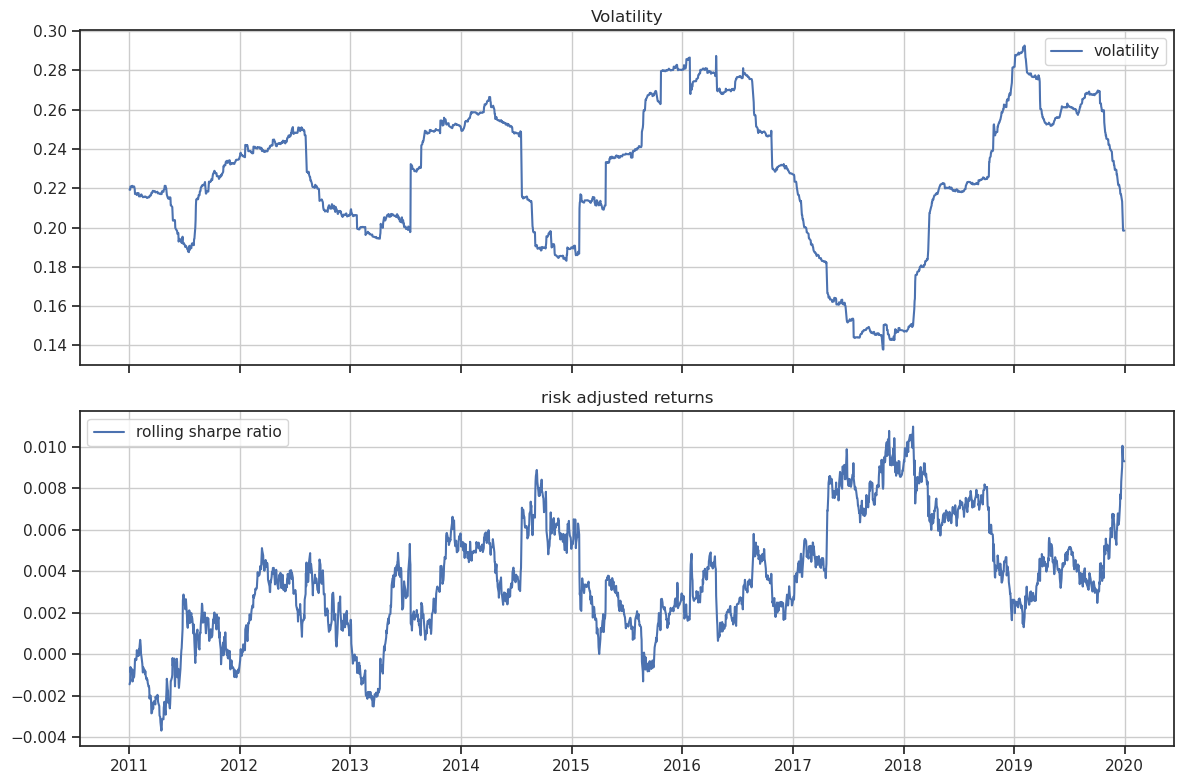

In [279]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,8))
ax[0].plot(vol_stock, label = 'volatility')

ax[0].set(title = 'Volatility')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(sharpe_stock, label = 'rolling sharpe ratio')
ax[1].set(title = 'risk adjusted returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
#save_fig("volatility_sharpe_msft")

## 5. How returns on stock correlates to returns on index

In [71]:
vti =pd.read_hdf('../data/assets.h5', 'yfinance/prices/train/vti')

In [72]:
vti.drop('Close', axis = 1, inplace = True)
vti = vti.rename(columns = {'Adj Close' : 'Close'})

In [73]:
vti.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,56.860001,57.380001,56.840000,44.859184,2251500
2010-01-05,57.340000,57.540001,57.110001,45.031384,1597700
2010-01-06,57.500000,57.720001,57.410000,45.093998,2120300
2010-01-07,57.549999,57.889999,57.290001,45.281864,1656700
2010-01-08,57.700001,58.049999,57.560001,45.430588,1650000


In [74]:
vti.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-04 to 2019-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Close   2515 non-null   float64
 4   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


In [75]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-04 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2515 non-null   float64
 1   High       2515 non-null   float64
 2   Low        2515 non-null   float64
 3   Close      2515 non-null   float64
 4   Volume     2515 non-null   int64  
 5   return_1d  2514 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 202.1 KB


In [76]:
vti['return_1d'] = np.log(vti.Close/vti.Close.shift(1))

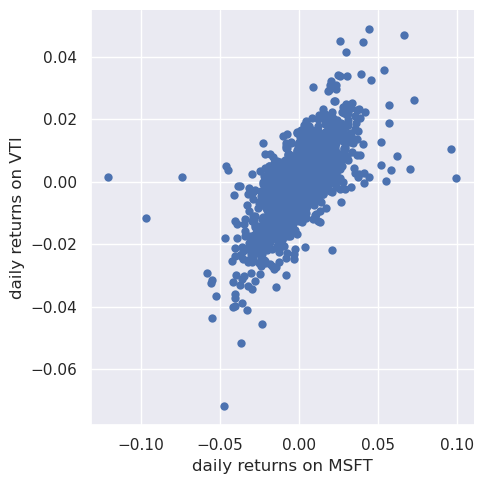

In [79]:
f, ax = plt.subplots(figsize=(5, 5))
sns.despine()
s = sns.scatterplot(x=stock.return_1d, y=vti.return_1d,
                sizes=(1, 8), linewidth=0,ax = ax)
s.set_xlabel('daily returns on MSFT')
s.set_ylabel('daily returns on VTI')
save_fig("corr_returns_VTI_MSFT")

# Results of Exploratory analysis

* Data is clean and free of outliers
* returns on invididual stocks exhibit non-normality
* past returns cannot reliably predict future return
* More features are required in order to predict returns
* Returns on MSFT are highly correlated with returns on VTI so it makes sense to use this ticker to build a model against passive returns on VTI
* We expect linear models to perform badly
* Due to non-normality of returns we expect linear models to perform badly


**The next step is to engineer features and do their analysis**
**This features will be feed to models and going forward we rely on regularization to figure out which features are better**